# Quantize Stable Diffusion with quanto

_Authored by: [Thomas Liang](https://github.com/thliang01)_


- Stable Diffusion models are a type of generative AI that specialize in creating high-quality images from textual descriptions. They leverage deep learning techniques to understand and translate text inputs into visual outputs. Quantization, particularly Post Training Quantization (PTQ), is a crucial process in optimizing these models for faster performance and reduced model size, making them more efficient for deployment.

## Install and setup

In [ ]:
! pip install --upgrade diffusers accelerate transformers safetensors datasets quanto
! pip install -q numpy Pillow torchmetrics[image] torch-fidelity

### Import modules

In [ ]:
import torch
import numpy as np
import os

import time
from time import perf_counter

from PIL import Image
from IPython import display as IPdisplay
from tqdm.auto import tqdm

from diffusers import DiffusionPipeline
from diffusers import DDIMScheduler
from transformers import logging

logging.set_verbosity_error()

### Check CUDA is available

In [ ]:
print(torch.cuda.is_available())

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Base Model

### Prompts and seeds

In [ ]:
queue = []

# Photorealistic portrait (Portrait)
queue.extend([{
  'prompt': '3/4 shot, candid photograph of a beautiful 30 year old redhead woman with messy dark hair, peacefully sleeping in her bed, night, dark, light from window, dark shadows, masterpiece, uhd, moody',
  'seed': 877866765,
}])

# Creative interior image (Interior)
queue.extend([{
  'prompt': 'futuristic living room with big windows, brown sofas, coffee table, plants, cyberpunk city, concept art, earthy colors',
  'seed': 5567822456,
}])

# Macro photography (Macro)
queue.extend([{
  'prompt': 'macro shot of a bee collecting nectar from lavender flowers',
  'seed': 2257899453,
}])

# Rendered 3D image (3D)
queue.extend([{
  'prompt': '3d rendered isometric fiji island beach, 3d tile, polygon, cartoony, mobile game',
  'seed': 987867834,
}])

### 

In [ ]:
model_name_or_path = "stabilityai/stable-diffusion-xl-base-1.0"
scheduler = DDIMScheduler.from_pretrained(model_name_or_path, subfolder="scheduler")
num_inference_steps = 50
height = 512
width = 512
generator = torch.manual_seed(42)

pipeline = DiffusionPipeline.from_pretrained(
    model_name_or_path,
    scheduler = scheduler,
    torch_dtype = torch.float16, 
    variant = "fp16",
    height = height,
    width = width,
    use_safetensors = True, 
    generator = generator,
    num_inference_steps = num_inference_steps,
).to(device)

pipeline.unet = torch.compile(pipeline.unet, mode='reduce-overhead', fullgraph=True)

### Display_images & Memory & Execution time

In [ ]:
prompt = "a photo of an astronaut riding a horse on mars"
start = time.time()
images = pipeline(prompt).images[0]
end = time.time()
mem_bytes = torch.cuda.max_memory_allocated()
images

In [ ]:
print(f"Memory: {mem_bytes/(10**6):.3f} MB")
print(f"Execution time: {(end - start):.3f} sec")

In [ ]:
# Create a generator
generator = torch.Generator(device='cuda')

# Start a loop to process prompts one by one
for i, generation in enumerate(queue, start=1):

  # We start the counter
  image_start = perf_counter()

  # Assign the seed to the generator
  generator.manual_seed(generation['seed'])

  # Create the image
  image = pipeline(
    prompt=generation['prompt'],
    generator=generator,
  ).images[0]

  # Save the image
  image.save(f'image_{i}.png')

  # We stop the counter and save the result
  generation['total_time'] = perf_counter() - image_start

# Print the generation time of each image
images_totals = ', '.join(map(lambda generation: str(round(generation['total_time'], 1)), queue))
print('Image time:', images_totals)

# Print the average time
images_average = round(sum(generation['total_time'] for generation in queue) / len(queue), 1)
print('Average image time:', images_average)

# Print the Max. memory used
max_memory = round(torch.cuda.max_memory_allocated(device='cuda') / 1000000000, 2)
print('Max. memory used:', max_memory, 'GB')

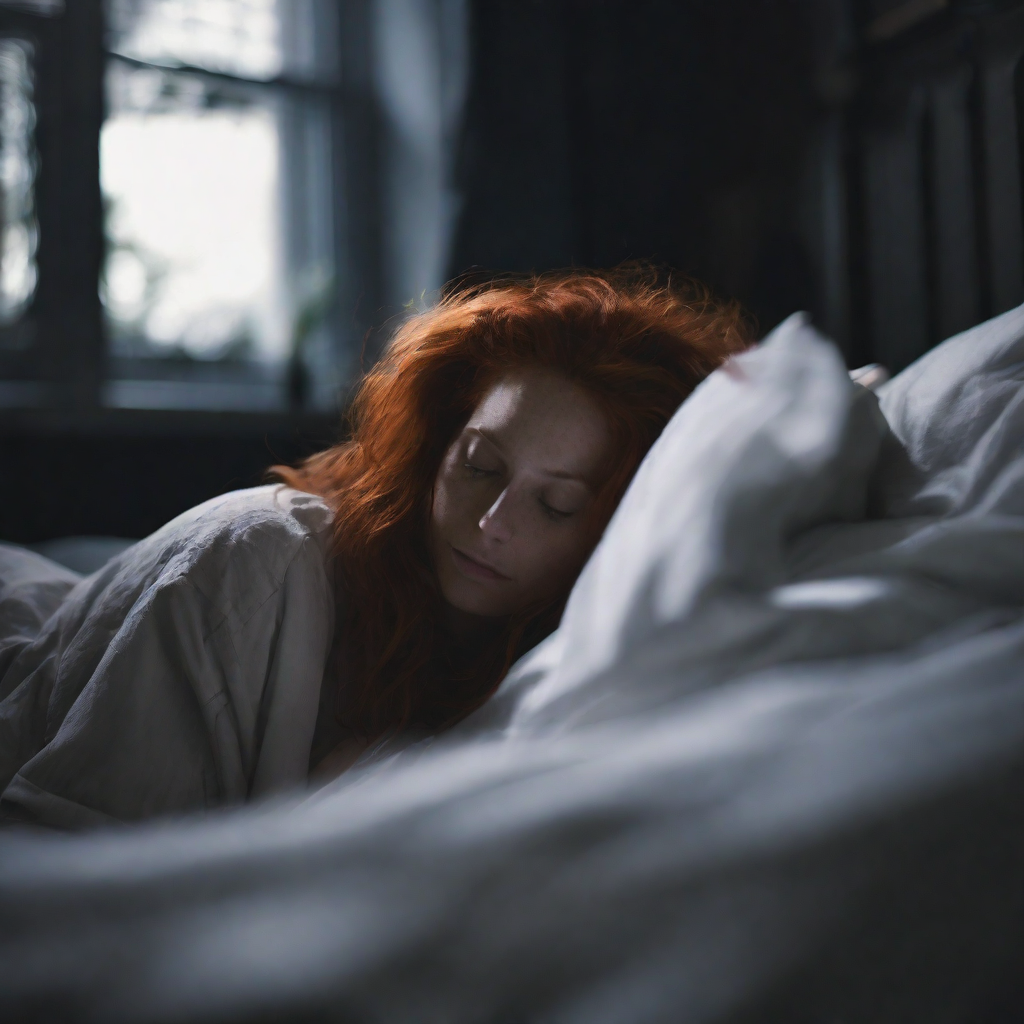

In [1]:
# Show the image
from PIL import Image

img1 = Image.open("image_1.png")
img1.show()

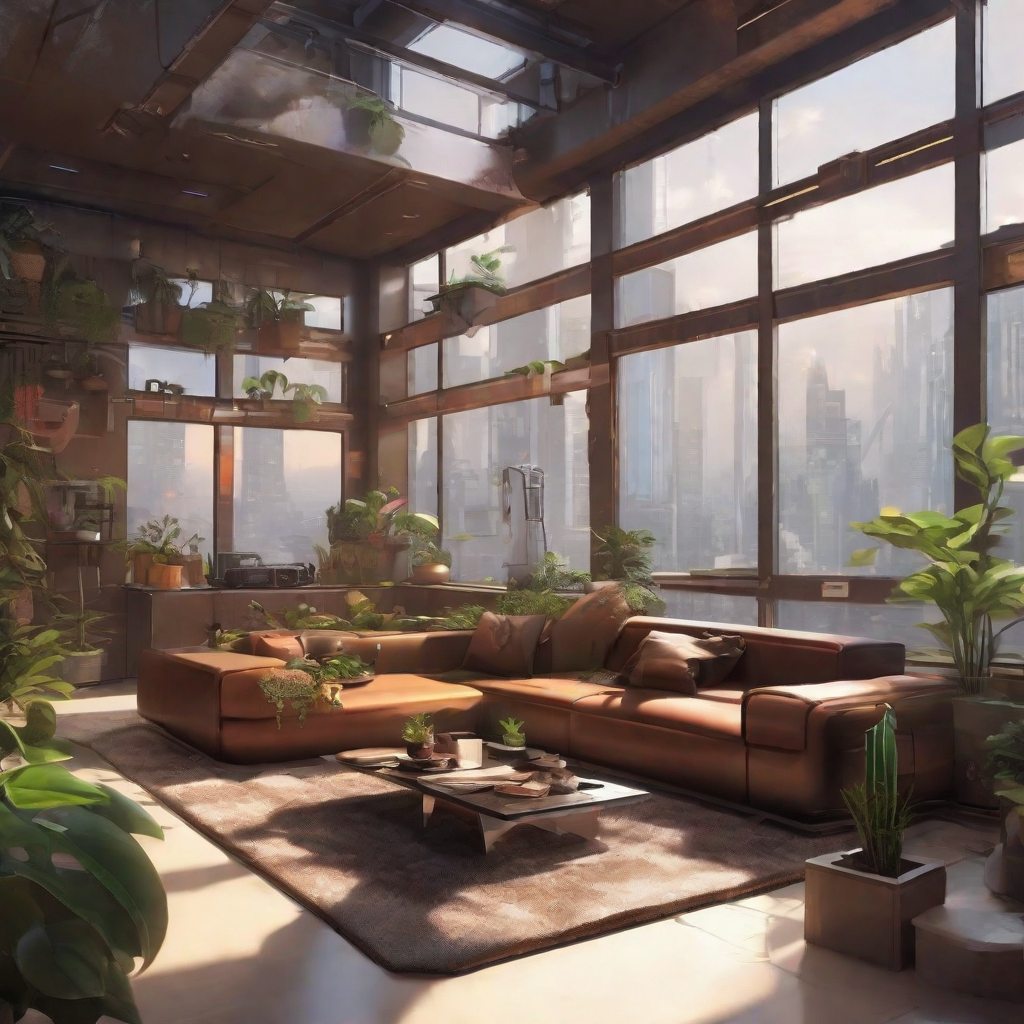

In [2]:
# Show the image
from PIL import Image

img2 = Image.open("image_2.png")
img2.show()

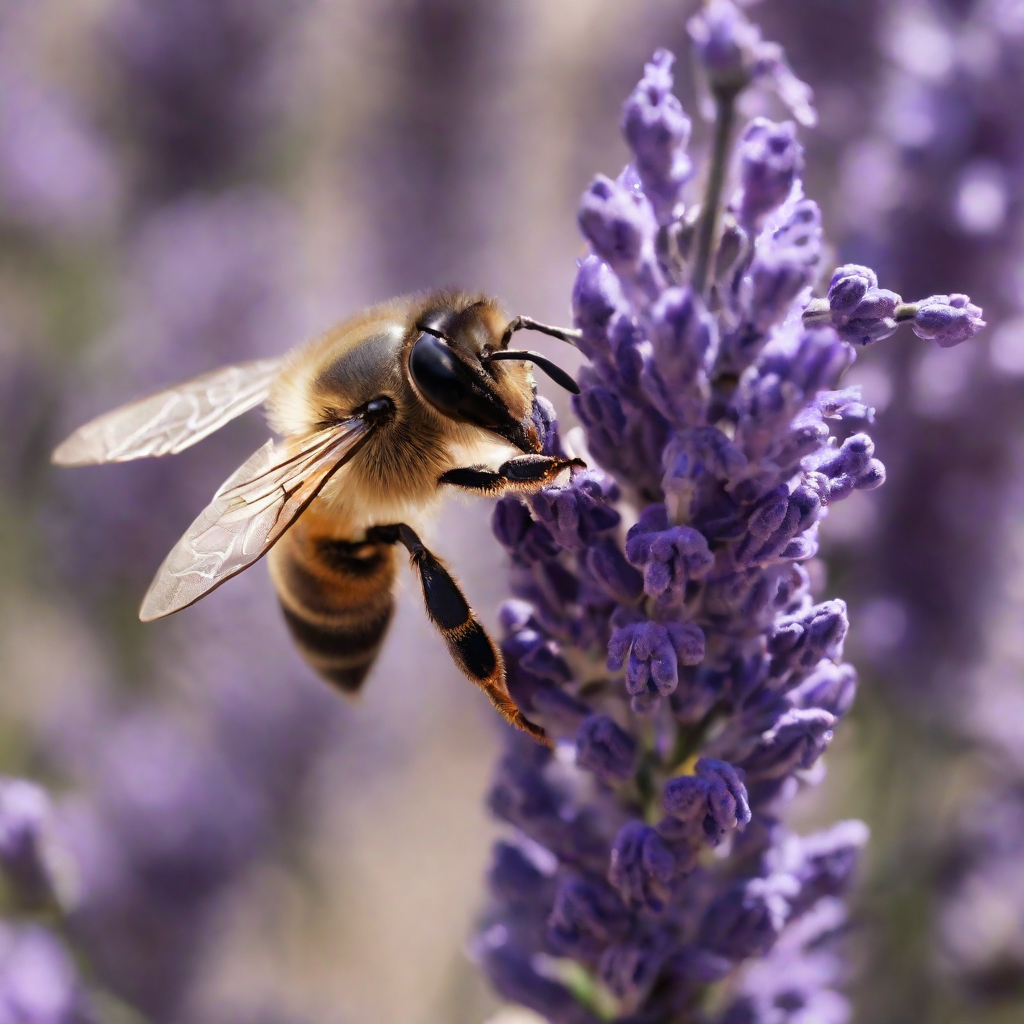

In [3]:
# Show the image
from PIL import Image

img3 = Image.open("image_3.png")
img3.show()

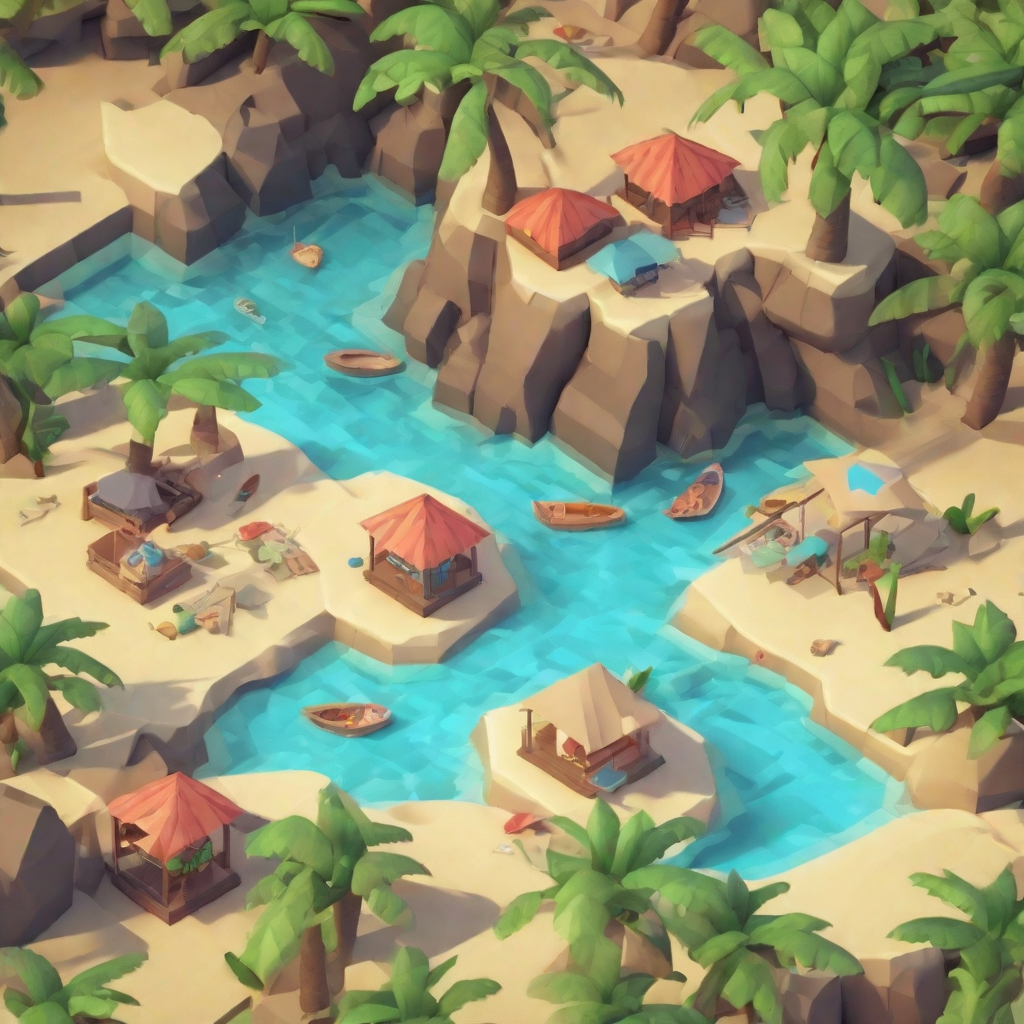

In [4]:
# Show the image
from PIL import Image

img4 = Image.open("image_4.png")
img4.show()

### Evaluating Diffusion Models (default)

* CLIP score
* PickScore

#### CLIP score

In [ ]:
prompts = [
    "a photo of an astronaut riding a horse on mars",
    "A high tech solarpunk utopia in the Amazon rainforest",
    "A pikachu fine dining with a view to the Eiffel Tower",
    "A mecha robot in a favela in expressionist style",
    "an insect robot preparing a delicious meal",
    "A small cabin on top of a snowy mountain in the style of Disney, artstation",
]

images = pipeline(prompts, num_images_per_prompt=1, output_type="np", height = height, width = width).images

print(images.shape)
# (6, 512, 512, 3)

In [ ]:
from torchmetrics.functional.multimodal import clip_score
from functools import partial

clip_score_fn = partial(clip_score, model_name_or_path="openai/clip-vit-base-patch16")

def calculate_clip_score(images, prompts):
    images_int = (images * 255).astype("uint8")
    clip_score = clip_score_fn(torch.from_numpy(images_int).permute(0, 3, 1, 2), prompts).detach()
    return round(float(clip_score), 4)

sd_clip_score = calculate_clip_score(images, prompts)
print(f"CLIP score: {sd_clip_score}")

#### PickScore

### TODO
![PickScore](https://huggingface.co/datasets/huggingface/cookbook-images/)

In [ ]:
# import
from transformers import AutoProcessor, AutoModel
from PIL import Image
import torch

# load model
device = "cuda"
processor_name_or_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
model_pretrained_name_or_path = "yuvalkirstain/PickScore_v1"
processor = AutoProcessor.from_pretrained(processor_name_or_path)
model = AutoModel.from_pretrained(model_pretrained_name_or_path).eval().to(device)

In [ ]:
# Score function adapted from their docs
def get_scores(prompt, images):
    
    # preprocess
    image_inputs = processor(
        images=images,
        padding=True,
        truncation=True,
        max_length=77,
        return_tensors="pt",
    ).to(device)
    
    text_inputs = processor(
        text=prompt,
        padding=True,
        truncation=True,
        max_length=77,
        return_tensors="pt",
    ).to(device)


    with torch.no_grad():
        # embed
        image_embs = model.get_image_features(**image_inputs)
        image_embs = image_embs / torch.norm(image_embs, dim=-1, keepdim=True)
    
        text_embs = model.get_text_features(**text_inputs)
        text_embs = text_embs / torch.norm(text_embs, dim=-1, keepdim=True)
    
        # score
        scores = model.logit_scale.exp() * (text_embs @ image_embs.T)[0]
       
    return scores.cpu().tolist()

In [ ]:
get_scores("a photo of an astronaut riding a horse on mars", images)

In [ ]:
get_scores("a photo of a pretty flower", images)

In [ ]:
from datasets import load_dataset
pap = load_dataset("yuvalkirstain/pickapic_v1_no_images")
prompts = pap['validation_unique']['caption']
prompts[:3]

#### Measuring the effect of CFG_Scale on Score


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

average_scores = []
cfg_scales = [2, 5, 9, 12, 30]
for cfg_scale in cfg_scales:
    scores = []
    for i, prompt in enumerate(prompts[:5]):
        print(f"Scale {cfg_scale}, prompt {i}")
        generator = generator # For reproducibility
        im = pipeline(prompt, num_inference_steps=50, 
                  generator=generator, guidance_scale=cfg_scale).images[0]
        scores.append(get_scores(prompt, im)[0])
        clear_output(wait=True)
    average_scores.append(sum(scores)/len(scores))

plt.plot(cfg_scales, average_scores)

#### Using A Score Model for Re-Ranking

In [ ]:
def generate_good_image(prompt):
    images = []
    # Generate 4 images with two different guidance scales (for example):
    images += pipeline(prompt, num_inference_steps=50, num_images_per_prompt=1,height = height, width = width).images
    images += pipeline(prompt, num_inference_steps=50, num_images_per_prompt=1,height = height, width = width, guidance_scale=5).images 
    # Score them and pick the best one
    scores = get_scores(prompt, images)
    best_image = images[scores.index(max(scores))]
    return best_image

generate_good_image("a photo of an astronaut riding a horse on mars")

## Quantization Stable Diffusion

* Post Training Quantization

In [ ]:
from quanto import quantize, freeze, qint8
import torch

model = "stabilityai/stable-diffusion-xl-base-1.0"

print(model)

In [ ]:
def PTQ(torch_dtype, unet_dtype=None, device="cuda"):
    pipe = DiffusionPipeline.from_pretrained(
        model, 
        torch_dtype=torch_dtype,
        scheduler = scheduler,
        height = height,
        width = width,
        generator = generator,
        num_inference_steps = num_inference_steps, 
        use_safetensors=True).to(device)

    if unet_dtype:
        quantize(pipe.unet, weights=unet_dtype)
        freeze(pipe.unet)

    pipe.set_progress_bar_config(disable=True)
    return pipe

In [ ]:
qpipe = PTQ(torch_dtype=torch.float16, unet_dtype=qint8)

## Display_images & Memory & Execution time

In [ ]:
prompt = "a photo of an astronaut riding a horse on mars"
start = time.time()
images = qpipe(prompt).images[0]
end = time.time()
mem_bytes = torch.cuda.max_memory_allocated()
images

In [ ]:
print(f"Memory: {mem_bytes/(10**6):.3f} MB")
print(f"Execution time: {(end - start):.3f} sec")

## Evaluating Diffusion Models (Post Training Quantization) After

* CLIP score
* PickScore

### CLIP score

In [ ]:
prompts = [
    "a photo of an astronaut riding a horse on mars",
    "A high tech solarpunk utopia in the Amazon rainforest",
    "A pikachu fine dining with a view to the Eiffel Tower",
    "A mecha robot in a favela in expressionist style",
    "an insect robot preparing a delicious meal",
    "A small cabin on top of a snowy mountain in the style of Disney, artstation",
]

images = qpipe(prompts, num_images_per_prompt=1, output_type="np", height = height, width = width).images

print(images.shape)
# (6, 512, 512, 3)

In [ ]:
from torchmetrics.functional.multimodal import clip_score
from functools import partial

clip_score_fn = partial(clip_score, model_name_or_path="openai/clip-vit-base-patch16")

def calculate_clip_score(images, prompts):
    images_int = (images * 255).astype("uint8")
    clip_score = clip_score_fn(torch.from_numpy(images_int).permute(0, 3, 1, 2), prompts).detach()
    return round(float(clip_score), 4)

sd_clip_score = calculate_clip_score(images, prompts)
print(f"CLIP score: {sd_clip_score}")

### PickScore

### TODO
![PickScore](https://huggingface.co/datasets/huggingface/cookbook-images/)

In [ ]:
# import
from transformers import AutoProcessor, AutoModel
from PIL import Image
import torch

# load model
device = "cuda"
processor_name_or_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
model_pretrained_name_or_path = "yuvalkirstain/PickScore_v1"
processor = AutoProcessor.from_pretrained(processor_name_or_path)
model = AutoModel.from_pretrained(model_pretrained_name_or_path).eval().to(device)

In [ ]:
# Score function adapted from their docs
def get_scores(prompt, images):
    
    # preprocess
    image_inputs = processor(
        images=images,
        padding=True,
        truncation=True,
        max_length=77,
        return_tensors="pt",
    ).to(device)
    
    text_inputs = processor(
        text=prompt,
        padding=True,
        truncation=True,
        max_length=77,
        return_tensors="pt",
    ).to(device)


    with torch.no_grad():
        # embed
        image_embs = model.get_image_features(**image_inputs)
        image_embs = image_embs / torch.norm(image_embs, dim=-1, keepdim=True)
    
        text_embs = model.get_text_features(**text_inputs)
        text_embs = text_embs / torch.norm(text_embs, dim=-1, keepdim=True)
    
        # score
        scores = model.logit_scale.exp() * (text_embs @ image_embs.T)[0]
       
    return scores.cpu().tolist()
get_scores("a photo of an astronaut riding a horse on mars", images)

In [ ]:
get_scores("a photo of a pretty flower", images)

In [ ]:
from datasets import load_dataset
pap = load_dataset("yuvalkirstain/pickapic_v1_no_images")
prompts = pap['validation_unique']['caption']
prompts[:3]

#### Measuring the effect of CFG_Scale on Score

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

average_scores = []
cfg_scales = [2, 5, 9, 12, 30]
for cfg_scale in cfg_scales:
    scores = []
    for i, prompt in enumerate(prompts[:5]):
        print(f"Scale {cfg_scale}, prompt {i}")
        generator = generator # For reproducibility
        im = qpipe(prompt, num_inference_steps=50, 
                  generator=generator, guidance_scale=cfg_scale).images[0]
        scores.append(get_scores(prompt, im)[0])
        clear_output(wait=True)
    average_scores.append(sum(scores)/len(scores))

plt.plot(cfg_scales, average_scores)

#### Using A Score Model for Re-Ranking

In [ ]:
def generate_good_image(prompt):
    images = []
    # Generate 4 images with two different guidance scales (for example):
    images += qpipe(prompt, num_inference_steps=50, num_images_per_prompt=1,height = height, width = width).images
    images += qpipe(prompt, num_inference_steps=50, num_images_per_prompt=1,height = height, width = width, guidance_scale=5).images 
    # Score them and pick the best one
    scores = get_scores(prompt, images)
    best_image = images[scores.index(max(scores))]
    return best_image

generate_good_image("a photo of an astronaut riding a horse on mars")

## Conclusion 

|  | Memory | Execution time |
| :-----| ----: | :----: |
| SDXL | 11238.718 MB | 19.318 sec |
| PTQ SDXL | 15787.444 MB | 23.972 sec |

|  | CLIP score | PickScore |
| :-----| ----: | :----: |
| SDXL | 31.4234 | 22.10 |
| PTQ SDXL | 33.096 | 22.1 |

## References

* [Diffusers](https://huggingface.co/docs/diffusers/)
* [Evaluating Diffusion Models](https://huggingface.co/docs/diffusers/conceptual/evaluation#text-guided-image-generation)
* [Pick-a-Pic: An Open Dataset of User Preferences for Text-to-Image Generation](https://arxiv.org/abs/2305.01569)
